# Finding the best heuristic weights with a GA

In [152]:
import subprocess
import random
import numpy as np
from subprocess import check_output
from IPython.display import clear_output

In [91]:
%pip install geneticalgorithm

     |████████████████████████████████| 44 kB 3.0 MB/s eta 0:00:011
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15077 sha256=bce8704a6374444a032759c63786282c32c472c3d8a27146e8a31ea3f7280074
  Stored in directory: /home/macdue/.cache/pip/wheels/a8/92/ca/5bbab358275e310af23b73fc32ebf37d6a7a08c87c8d2cdbc1
Successfully built func-timeout
Note: you may need to restart the kernel to use updated packages.


In [92]:
from geneticalgorithm import geneticalgorithm as ga

In [139]:
OUR_BOT = "cargo run --bin mankalah --release -- --search=alpha-beta --weights {} --depth {}"
OPP_BOT = "java -jar ../MKRefAgent.jar"

In [170]:
def execute(cmd):
    cmd = ' '.join(cmd)
    popen = subprocess.Popen(cmd, stderr=subprocess.PIPE, universal_newlines=True, shell=True)
    for line in iter(popen.stderr.readline, ""):
        yield line 
    popen.stderr.close()
    return_code = popen.wait()
    if return_code:
        raise subprocess.CalledProcessError(return_code, cmd)

In [228]:
def run_bot(start_south, weights, depth = 10):
    if len(weights) != 5:
        raise Exception("5 weights needed")
    p1 = OUR_BOT.format(' '.join(map(str, weights)), depth)
    p2 = OPP_BOT
    if not start_south:
        p2, p1 = p1, p2
    try:
        return [*execute(["java", "-jar", "../ManKalah.jar", f'"{p1}"', f'"{p2}"'])]
    except subprocess.CalledProcessError as run_e:
        print(run_e.returncode, run_e.output)
        raise run_e

In [148]:
def parse_result(res):
    p1_info  = res[-3].rsplit(':')[1].split()
    p1_moves = int(p1_info[0])
    p1_time = int(p1_info[2])
    
    p2_info  = res[-2].rsplit(':')[1].split()
    p2_moves = int(p2_info[0])
    p2_time = int(p2_info[2])
    
    score_line = res[-6]
    
    if "DRAW" in score_line:
        winner = 0
    else:
        winner = int(score_line.split()[2]);
        if winner == 2:
            winner = -1

    return {
        "winner":winner,
        "score": int(res[-5].split()[1]),
        "p1_turns": p1_moves,
        "p1_time": p1_time,
        "p2_turns": p2_moves,
        "p2_time": p2_time
    }

In [230]:
max_show = 10
shown = 0
def f(X):
    global shown, max_show
    start_south = bool(random.getrandbits(1))
    search_depth = random.randint(5, 9)
    X = [float(x/100) for x in X]
    res = parse_result(run_bot(start_south, X[:5], search_depth))
    winner = res["winner"]
    score_scale = -winner if start_south else winner
    res["ga_score"] = res["score"] * score_scale
    print(f"start = {('North', 'South')[int(start_south)]}, depth = {search_depth} res = {res}, weights = {X}")
    shown += 1
    if shown > max_show:
        shown = 0
        clear_output(wait=True) # helps logging
    return res["ga_score"] # ga finds min

In [234]:
vartype = np.array([['int'],['int'],['int'],['int'],['int']])
varbound = np.array([[0,100],[0,100],[0,100],[0,100],[0,100]])
model = ga(function=f, dimension=5, variable_type_mixed=vartype, variable_boundaries=varbound, function_timeout=100, algorithm_parameters={
    'max_num_iteration': 50,
    'population_size': 100,
    'mutation_probability': 0.1,
    'elit_ratio': 0.01,
    'crossover_probability': 0.5,
    'parents_portion': 0.3,
    'crossover_type':'uniform',
    'max_iteration_without_improv': 20})

start = South, depth = 5 res = {'winner': 1, 'score': 2, 'p1_turns': 25, 'p1_time': 2, 'p2_turns': 17, 'p2_time': 0, 'ga_score': -2}, weights = [0.41, 0.73, 0.71, 0.29, 0.52]
start = North, depth = 8 res = {'winner': -1, 'score': 6, 'p1_turns': 32, 'p1_time': 0, 'p2_turns': 43, 'p2_time': 60, 'ga_score': -6}, weights = [0.89, 0.39, 0.48, 0.35, 0.12]
start = South, depth = 5 res = {'winner': -1, 'score': 4, 'p1_turns': 30, 'p1_time': 2, 'p2_turns': 26, 'p2_time': 0, 'ga_score': 4}, weights = [0.81, 0.43, 0.71, 0.35, 0.09]
 The best solution found:                                                                           
 [89. 39. 48. 58.  8.]

 Objective function:
 -80.0


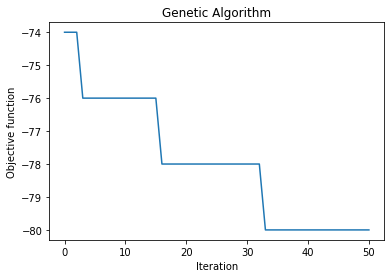

In [235]:
model.run()